In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from os import listdir
from os.path import isfile, join
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


In [3]:
centers = brain = "r1"
dir = "precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/Ch_647"
vol_fg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
print(vol_fg.shape)

centers = [
    [2011.743408203125, 2835.38671875, 1535.5],
    [2430.76171875, 3053.81494140625, 713.5],
    [1780.8623046875, 2691.490234375, 1538.5001220703125],
    [1642.8656005859375, 3693.246337890625, 1540.4998779296875],
    [1924.112060546875, 2812.427978515625, 1539.5],
    [2228.993896484375, 3124.892333984375, 710.4999389648438],
    [976.0220336914062, 2615.152587890625, 1295.4998779296875],
    [2246.654296875, 4579.09912109375, 1681.5],
    [2383.7158203125, 2945.70166015625, 768.5000610351562],
    [2287.11474609375, 3137.698486328125, 713.5],
    [3852.977783203125, 5670.54296875, 1325.5],
    [785.1561889648438, 2881.677978515625, 1418.5],
    [3049.8564453125, 5896.8427734375, 1018.5],
    [3077.5703125, 4926.2783203125, 1903.4998779296875],
    [1411.1312255859375, 4952.9912109375, 1653.4998779296875],
    [2617.185546875, 3935.150146484375, 1544.5],
    [1847.7435302734375, 3412.42529296875, 1539.5],
    [2568.662109375, 4020.066162109375, 1544.5],
    [2636.25927734375, 2863.755615234375, 956.5],
    [3214.722412109375, 5058.56689453125, 1903.4998779296875],
    [3381.364501953125, 5440.7744140625, 716.5],
    [2136.887451171875, 3078.10009765625, 712.4999389648438],
    [3805.26220703125, 5721.7451171875, 951.5000610351562],
    [2653.3818359375, 5837.59521484375, 894.5],
    [3070.020263671875, 3609.991943359375, 1418.5001220703125],
    [2138.659423828125, 2925.73681640625, 998.5000610351562],
    [3354.067626953125, 4763.74365234375, 706.5],
    [3323.818603515625, 5509.31494140625, 1012.5],
    [2382.930908203125, 5729.60888671875, 865.5],
    [2535.490234375, 2913.681396484375, 1531.5001220703125],
    [2822.101318359375, 5940.8447265625, 870.4999389648438],
    [3124.767578125, 3648.263427734375, 1415.5],
    [1567.5830078125, 2865.05859375, 1543.5],
    [1854.7235107421875, 3435.424072265625, 707.5],
    [1830.0322265625, 3484.5322265625, 708.5],
    [2262.647705078125, 5039.2021484375, 1647.5001220703125],
    [3200.597412109375, 5456.03173828125, 1322.5],
    [3243.903564453125, 4821.22607421875, 1903.4998779296875],
    [1673.142822265625, 3517.357666015625, 1540.5],
    [2999.173095703125, 4204.28271484375, 1639.5],
    [3006.562744140625, 4938.923828125, 1900.4998779296875],
    [2886.84716796875, 4451.986328125, 1665.5],
    [2811.046142578125, 5642.18701171875, 1671.5],
    [2037.578125, 4099.0029296875, 1909.4998779296875],
    [2907.236083984375, 4148.60107421875, 1664.5],
    [1602.658447265625, 5768.17724609375, 1487.5001220703125],
    [3856.97119140625, 4785.84375, 857.5],
    [1390.650390625, 3785.47607421875, 965.5],
    [1575.3089599609375, 2840.33544921875, 1542.5],
    [3515.720458984375, 5792.529296875, 1298.5],
    [2600.551513671875, 4095.101806640625, 1625.5001220703125],
    [3057.936767578125, 4192.6103515625, 1639.5],
    [3038.3564453125, 5691.2783203125, 683.5],
    [846.10400390625, 2795.954833984375, 1418.5],
    [2105.562744140625, 3077.30859375, 1352.5001220703125],
    [1439.8948974609375, 3693.8486328125, 730.4999389648438],
    [3055.538330078125, 4010.5537109375, 1539.4998779296875],
    [3415.8681640625, 5375.50439453125, 1374.5],
    [3523.255126953125, 3717.175048828125, 1638.5],
    [2503.846923828125, 3003.74267578125, 1541.5001220703125],
    [1884.9224853515625, 2402.20849609375, 1678.5],
    [3248.570068359375, 5417.93310546875, 688.5],
    [2692.116455078125, 4005.279052734375, 1538.5],
    [3563.275634765625, 3705.658447265625, 1649.4998779296875],
    [2643.770751953125, 5856.18603515625, 1472.5001220703125],
    [2928.4404296875, 4202.427734375, 1675.5],
    [953.2669677734375, 2733.28125, 1309.5001220703125],
    [3091.98779296875, 3658.0458984375, 1415.5],
    [1855.5592041015625, 2653.33349609375, 1537.5],
    [1412.1038818359375, 3816.89013671875, 944.5],
    [2335.27001953125, 6059.69287109375, 1400.5001220703125],
    [1119.7874755859375, 2634.51416015625, 1298.5],
    [1957.525146484375, 4067.762939453125, 1902.5],
    [942.6224975585938, 2604.65576171875, 1289.5],
    [1973.50634765625, 2371.421142578125, 1679.5],
    [2820.294921875, 4667.92822265625, 1910.5],
    [3765.234375, 5184.81494140625, 945.5000610351562],
    [3022.6396484375, 3871.55029296875, 1821.5001220703125],
    [3415.100341796875, 4669.4833984375, 1899.5],
    [1424.1728515625, 3417.180419921875, 1546.5001220703125],
    [3486.880615234375, 5367.294921875, 691.5],
    [3473.42138671875, 4550.96630859375, 1674.4998779296875],
    [3116.014892578125, 3670.91748046875, 1420.5001220703125],
    [2862.326416015625, 4161.21630859375, 1652.5],
    [3097.629638671875, 4741.66015625, 2023.5],
    [1919.5633544921875, 3037.014892578125, 715.5],
    [1947.3941650390625, 2633.284912109375, 1526.4998779296875],
    [2806.36083984375, 3986.090576171875, 1539.4998779296875],
    [2474.282958984375, 3113.071044921875, 713.5],
    [2144.11767578125, 3158.352783203125, 1352.5001220703125],
    [2958.302490234375, 2309.1650390625, 984.5],
    [3150.5234375, 4555.67626953125, 1900.4998779296875],
    [2712.485595703125, 3920.850341796875, 1549.4998779296875],
    [3850.980712890625, 4883.8349609375, 864.4999389648438],
    [3039.634765625, 4971.02294921875, 1903.4998779296875],
    [3015.31689453125, 4547.89453125, 1902.499755859375],
    [2083.13671875, 4309.87451171875, 1899.5],
    [3471.501953125, 4553.08544921875, 1656.4998779296875],
    [2458.521240234375, 3214.04345703125, 713.5],
    [3287.51318359375, 5237.70654296875, 709.5000610351562]
]

nonsoma_centers = [
    [3717.254150390625, 4600.33984375, 2236.5],
    [2405.4306640625, 3981.74853515625, 799.4999389648438],
    [2450.216064453125, 2035.8717041015625, 1388.5],
    [1393.8924560546875, 2702.320068359375, 907.5],
    [2197.689208984375, 5329.3505859375, 1559.4998779296875],
    [2732.838134765625, 3567.6171875, 1556.4998779296875],
    [901.0664672851562, 4493.27197265625, 1695.4998779296875],
    [2473.236328125, 3967.60546875, 907.5000610351562],
    [1349.7891845703125, 4999.54443359375, 1699.5],
    [3879.52734375, 5786.0390625, 1399.5],
    [1820.3192138671875, 4988.37841796875, 799.4999389648438],
    [1743.709716796875, 2824.9189453125, 1373.5],
    [3654.88720703125, 4952.98291015625, 1387.4998779296875],
    [2422.846435546875, 5315.03271484375, 1702.5],
    [1102.1307373046875, 1870.1595458984375, 1854.5001220703125],
    [3086.711181640625, 4087.082763671875, 1875.5],
    [3545.043212890625, 5263.32861328125, 1387.5],
    [3005.282470703125, 3506.512451171875, 1550.5],
    [2897.065185546875, 3204.1494140625, 1300.5001220703125],
    [3271.374755859375, 4756.33642578125, 1557.5]
]

nonsoma_centers2 = [[518,4516, 3001], [2287, 4660, 3001], [451, 5893, 3210], [518, 4421, 3268], [1311, 6546, 3268], [3918, 5896, 796],
                    [378, 6549, 3270], [30, 6212, 3270], [401, 6266, 3270], [92, 6539, 3270]]
soma_centers2 = [[3596, 5609, 803], [2598, 5486, 770], [2652, 5673, 786], [2303, 2849, 749]]

(5602, 7360, 3300, 1)


In [ ]:
dset_name = "test"
type = "neg"

for i, center in enumerate(nonsoma_centers2):
    if i in [2, 3, 4, 8, 9]:
        image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
        image_fg = image_fg[:,:,:,0]

        image_1channel = np.squeeze(np.stack([image_fg], axis=0))
            
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain" + brain + "/" + dset_name + "2_" + str(i) + "_" + type + ".h5"
        with h5py.File(fname, "w") as f:
            dset = f.create_dataset("image_3channel", data=image_1channel)
        

100%|██████████| 29/29 [00:00<00:00, 220.45it/s]


threshold: 0.05: precision: 0.15384615384615385, recall: 1.0, f-score: 0.2666666666666667 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 349.74it/s]


threshold: 0.1: precision: 0.19444444444444445, recall: 1.0, f-score: 0.32558139534883723 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 361.43it/s]


threshold: 0.15000000000000002: precision: 0.2413793103448276, recall: 1.0, f-score: 0.3888888888888889 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 366.86it/s]


threshold: 0.2: precision: 0.3333333333333333, recall: 1.0, f-score: 0.5 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 358.84it/s]


threshold: 0.25: precision: 0.3783783783783784, recall: 1.0, f-score: 0.5490196078431372 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 368.50it/s]


threshold: 0.3: precision: 0.42424242424242425, recall: 1.0, f-score: 0.5957446808510638 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 365.61it/s]


threshold: 0.35000000000000003: precision: 0.4375, recall: 1.0, f-score: 0.6086956521739131 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 377.29it/s]


threshold: 0.4: precision: 0.5, recall: 1.0, f-score: 0.6666666666666666 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 370.69it/s]


threshold: 0.45: precision: 0.5384615384615384, recall: 1.0, f-score: 0.7000000000000001 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 370.66it/s]


threshold: 0.5: precision: 0.7368421052631579, recall: 1.0, f-score: 0.8484848484848484 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 368.04it/s]


threshold: 0.55: precision: 0.8235294117647058, recall: 1.0, f-score: 0.9032258064516129 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 372.79it/s]


threshold: 0.6000000000000001: precision: 0.9333333333333333, recall: 1.0, f-score: 0.9655172413793104 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 381.77it/s]


threshold: 0.6500000000000001: precision: 1.0, recall: 1.0, f-score: 1.0 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 384.02it/s]


threshold: 0.7000000000000001: precision: 1.0, recall: 0.9285714285714286, f-score: 0.962962962962963 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 377.03it/s]


threshold: 0.7500000000000001: precision: 1.0, recall: 0.8571428571428571, f-score: 0.923076923076923 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 388.73it/s]


threshold: 0.8: precision: 0.9230769230769231, recall: 0.8571428571428571, f-score: 0.888888888888889 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 383.93it/s]


threshold: 0.8500000000000001: precision: 0.9090909090909091, recall: 0.7142857142857143, f-score: 0.8 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 379.86it/s]


threshold: 0.9000000000000001: precision: 1.0, recall: 0.7142857142857143, f-score: 0.8333333333333333 for 14 positive samples in 29 images


100%|██████████| 29/29 [00:00<00:00, 386.44it/s]

threshold: 0.9500000000000001: precision: 1.0, recall: 0.6428571428571429, f-score: 0.782608695652174 for 14 positive samples in 29 images


<matplotlib.legend.Legend object at 0x15682f940>

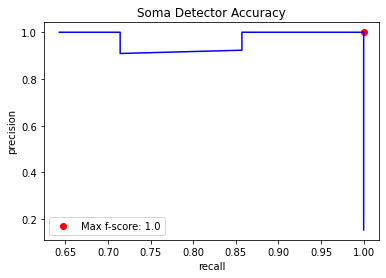

In [4]:
recalls = []
precisions = []

files_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain" + brain + "/"
onlyfiles = [f for f in listdir(files_dir) if isfile(join(files_dir, f))]
test_files = [f for f in onlyfiles if f[:4] == "test"]
test_files = [f for f in test_files if len(f.split("_"))== 4] #"probabilities"

for threshold in np.arange(0.05,1.0,0.05):
    tot_pos = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files):
        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[:,:,:,0]
        mask = pred>threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        parts = filename.split("_")
        if parts[2] == "pos":
            first = True
            tot_pos += 1
            for prop in props:
                if prop["area"] > 50:
                    if first:
                        true_pos += 1
                        first = False
                    else:
                        false_pos += 1
        elif parts[2] == "neg":
            for prop in props:
                if prop["area"] > 50:
                    false_pos += 1

    recall = true_pos/tot_pos
    recalls.append(recall)
    precision = true_pos/(true_pos + false_pos)
    precisions.append(precision)
    print(f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {2*precision*recall/(precision+recall)} for {tot_pos} positive samples in {len(test_files)} images")

fscores = [2*precision*recall/(precision+recall) for precision,recall in zip(precisions, recalls)]
idx = np.argmax(fscores)
plt.plot(recalls, precisions, c='b')
plt.scatter(recalls[idx], precisions[idx], c='r', label=f"Max f-score: {fscores[idx]}")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Soma Detector Accuracy")
plt.legend()


## make point layer - ?????

In [ ]:

point_path = "precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/point_preds"
info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    # raw, jpeg, compressed_segmentation, fpzip, kempressed, compresso
    encoding        = 'raw', 
    resolution      = [4, 4, 40], # Voxel scaling, units are in nanometers
    voxel_offset    = [0, 0, 0], # x,y,z offset in voxels from the origin
    mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 512, 512, 16 ], # units are voxels
    volume_size     = [ 250000, 250000, 25000 ], # e.g. a cubic millimeter dataset
)
vol = CloudVolume(point_path, info=info)
vol.commit_info()